# Получаем курсы валют по API

**Задача:** получить актуальные значения курса валют на данный момент с использованием API из различных источников. Включая сайт ЦБ РФ, библиотеку pycbrf и запросы к сторонним сайтам.

Список библиотек

In [145]:
import requests
import pandas as pd
from datetime import datetime
import xml.etree.ElementTree as ET
from pycbrf import ExchangeRates, Banks

## Получим JSON данные с сайта *cbr-xml-daily.ru*

Подключаем библиотеки для осуществеления запроса и для преобразования результата в датафрейм пандас.

Получаем данные по API

In [146]:
data_json = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()

Преобразовываем полученый JSON в DataFrame.

In [147]:
data_valute = pd.DataFrame(data_json['Valute'])
#Оставим только данные о некоторых валютах.
data_valute = data_valute[['USD', 'EUR', 'BYN', 'KZT', 'KRW']]
#транспонируем для удобства
data_valute = data_valute.T

Добавим нормализинованные столбцы Value

In [148]:
data_valute['текущее_значение'] = data_valute['Value']/data_valute['Nominal']
data_valute['предыдущее_значение'] = data_valute['Previous']/data_valute['Nominal']

### Выведем полученные данные

<Axes: title={'center': 'Актуальные курсы валют на 2024-02-23 11:30:00'}>

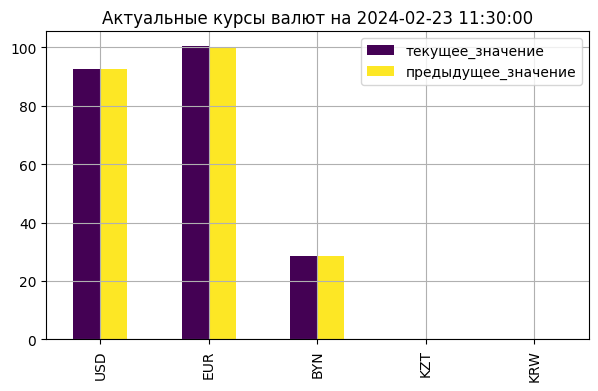

In [149]:
#скорректируем формат даты
actual_date = datetime.strptime(data_json['Date'].split('+')[0], "%Y-%m-%dT%H:%M:%S")

data_valute[['текущее_значение', 'предыдущее_значение']].plot(kind='bar',
                                                              title = 'Актуальные курсы валют на ' + str(actual_date),
                                                              figsize = [7, 4],
                                                              colormap = 'viridis',
                                                              grid = True
                                                              )

In [150]:
#выведем заголовок
print('Актуальные курсы валют на ' + str(actual_date))

#преобразуем типы для округления
data_valute['текущее_значение'] = data_valute['текущее_значение'].astype(float)
data_valute['предыдущее_значение'] = data_valute['предыдущее_значение'].astype(float)

#выведем таблицу
data_valute[['текущее_значение', 'предыдущее_значение']].round(3)

Актуальные курсы валют на 2024-02-23 11:30:00


,текущее_значение,предыдущее_значение
USD,92.752,92.439
EUR,100.442,99.897
BYN,28.564,28.545
KZT,0.206,0.204
KRW,0.070,0.069


## Получим XML данные с официального сайта ЦБ РФ

Получим данные в формате XML.

In [151]:
cb_url_daily = 'https://www.cbr.ru/scripts/XML_daily.asp'
res = requests.get(cb_url_daily)

При помощи библиотеки *ElementTree*  преобразуем XML-верстку в dataframe

In [152]:
root = ET.fromstring(res.content)
#создадим побочный лист
data_cb_list = []
#циклом выберем нужные значения
for currency in root.findall('Valute'):
    row = {
            'Название': currency.find('Name').text,
            'Код': currency.find('CharCode').text,
            'Номинал': currency.find('Nominal').text,
            'Значение': currency.find('Value').text
        }
    data_cb_list.append(row)
#преобразуем лист в датафрейм
df_cb_list = pd.DataFrame(data_cb_list)

### Выведем полученные данные

In [153]:
#Установим сокращение валюты как индекс
df_cb_list = df_cb_list.set_index('Код')

In [154]:
df_cb_list.head()

,Название,Номинал,Значение
Код,,,
AUD,Австралийский доллар,1,"60,8360"
AZN,Азербайджанский манат,1,"54,5599"
GBP,Фунт стерлингов Соединенного королевства,1,"116,9787"
AMD,Армянских драмов,100,"22,9380"
BYN,Белорусский рубль,1,"28,5645"


Выведем текущий курс USD.

In [155]:
print('Текущий курс валюты: {} по данным ЦБ равен {} р.'.format(df_cb_list['Название']['USD'], df_cb_list['Значение']['USD']))

Текущий курс валюты: Доллар США по данным ЦБ равен 92,7519 р.


## Получим данные через библиотеку pycbr

Получим актуальную информацию из библиотеки pycbr на текущую дату.

In [156]:
#создадим обект rates с информацией о различных валютах на текущее время
rates = ExchangeRates(datetime.now().date())

### Выведем полученные данные

Выведем несколько курсов валют.

In [157]:
#создадим список с интересующими валютами
currencies = ['USD', 'EUR', 'KZT']

#выведем в цикле все валюты из списка
for curr_name in currencies:
    #выводим rate
    print('Текущий курс валюты: {} по данным ЦБ равен {} р.'.format(rates[curr_name].name, rates[curr_name].rate))

Текущий курс валюты: Доллар США по данным ЦБ равен 92.7519 р.
Текущий курс валюты: Евро по данным ЦБ равен 100.4425 р.
Текущий курс валюты: Казахстанских тенге по данным ЦБ равен 0.20575 р.
